<a href="https://colab.research.google.com/github/rickiepark/MLQandAI/blob/main/supplementary/q25_confidence-intervals/1_four-methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신뢰 구간 구성하기

In [ ]:
!pip install --quiet watermark

%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p numpy,mlxtend,matplotlib,sklearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.7 MB/s eta 0:00:00
Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 7.34.0

numpy     : 1.26.4
mlxtend   : 0.23.3
matplotlib: 3.10.0
sklearn   : 1.6.0



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## 실습을 위해 데이터셋과 모델 정의하기

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

digits = load_digits()

X = digits.data / 16. - 0.5 # 데이터셋을 -0.5 ~ 0.5 범위로 정규화합니다
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=123, stratify=y
)

clf = MLPClassifier(
    hidden_layer_sizes=(10,),
    activation="relu",
    learning_rate_init=0.01,
    random_state=123,
    solver="adam",
    max_iter=500
)

## 1) 테스트 세트 기반의 정규 근사 구간

- 통계 교과서에 실린 $z$ 표를 찾는 대신 `scipy.stats.norm.ppf`를 사용해 z-값을 구합니다.

In [ ]:
import scipy.stats

confidence = 0.95  # 원하는 신뢰 수준으로 바꾸세요
z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
print(z_value)

1.959963984540054


- 다음으로 분류기의 테스트 정확도를 계산하고, 이 값을 위 공식에 대입합니다. 파이썬 코드는 다음과 같습니다:

In [ ]:
import numpy as np

clf.fit(X_train, y_train)

acc_test = clf.score(X_test, y_test)
ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])

ci_lower = acc_test - ci_length
ci_upper = acc_test + ci_length

print(ci_lower, ci_upper)

0.9601953017724117 0.9953602537831437


- 다음 코드로 신뢰 구간을 시각화해 보죠:

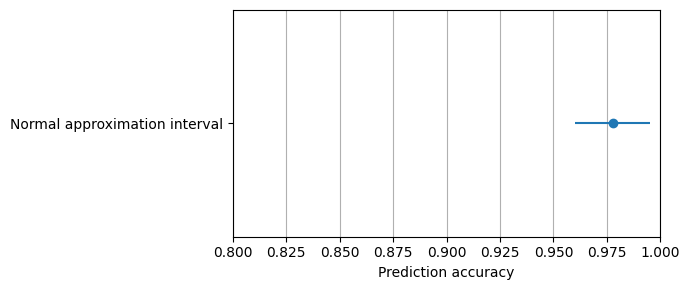

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 3))

ax.errorbar(acc_test, 0, xerr=ci_length, fmt="o")

ax.set_xlim([0.8, 1.0])

ax.set_yticks(np.arange(1))
ax.set_yticklabels(["Normal approximation interval"])
ax.set_xlabel("Prediction accuracy")

plt.tight_layout()
plt.grid(axis="x")
plt.show()

- 마지막으로 나중에 다른 신뢰 구간과 비교할 때 사용하기 위해 신뢰 구간을 파이썬 딕셔너리로 저장합니다:

In [ ]:
results = {
    "Method 1: Normal approximation": {
        "Test accuracy": acc_test,
        "Lower 95% CI": ci_lower,
        "Upper 95% CI": ci_upper,
    }
}

## 2) 훈련 세트 부트스트래핑하기

In [ ]:
import numpy as np

rng = np.random.RandomState(seed=12345)
idx = np.arange(y_train.shape[0])

bootstrap_train_accuracies = []
bootstrap_rounds = 200


for i in range(bootstrap_rounds):

    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    valid_idx = np.setdiff1d(idx, train_idx, assume_unique=False)

    boot_train_X, boot_train_y = X_train[train_idx], y_train[train_idx]
    boot_valid_X, boot_valid_y = X_train[valid_idx], y_train[valid_idx]

    clf.fit(boot_train_X, boot_train_y)
    acc = clf.score(boot_valid_X, boot_valid_y)
    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)
bootstrap_train_mean

0.9553670076911844

- 부트스트래핑 테스트 정확도($ \text{ACC}_{\text{boot}, j}$)와 샘플 평균($\text{ACC}_{\text{bootavg}}$)을 히스토그램으로 시각화할 수 있습니다.

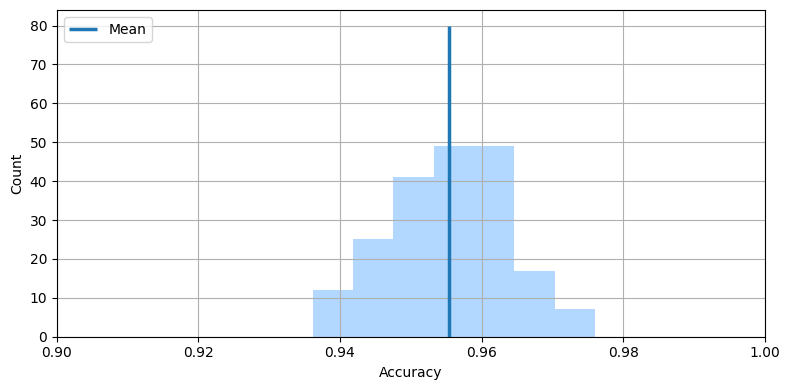

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.vlines(bootstrap_train_mean, [0], 80, lw=2.5, linestyle="-", label="Mean")

ax.hist(
    bootstrap_train_accuracies, bins=7, color="#0080ff", edgecolor="none", alpha=0.3
)
plt.legend(loc="upper left")

plt.xlim([0.9, 1.0])

plt.xlabel('Accuracy')
plt.ylabel('Count')

plt.tight_layout()
plt.grid()
plt.show()

#### 백분위 방법 사용하기

In [ ]:
ci_lower = np.percentile(bootstrap_train_accuracies, 2.5)
ci_upper = np.percentile(bootstrap_train_accuracies, 97.5)

print(ci_lower, ci_upper)

0.9403296497471437 0.970772977022977


- 앞의 그림에 나타내 보죠.

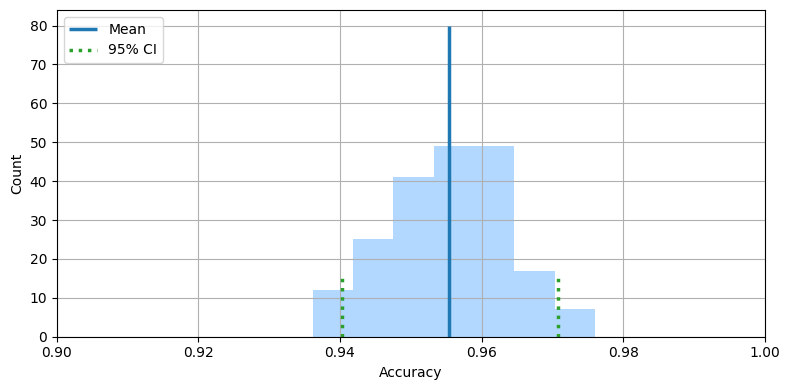

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(bootstrap_train_mean, [0], 80, lw=2.5, linestyle="-", label="Mean")

ax.vlines(ci_lower, [0], 15, lw=2.5, linestyle="dotted", label="95% CI", color="C2")
ax.vlines(ci_upper, [0], 15, lw=2.5, linestyle="dotted", color="C2")

ax.hist(
    bootstrap_train_accuracies, bins=7, color="#0080ff", edgecolor="none", alpha=0.3
)
plt.legend(loc="upper left")

plt.xlim([0.9, 1.0])
plt.xlabel('Accuracy')
plt.ylabel('Count')

plt.tight_layout()
plt.grid()

plt.show()

In [ ]:
results["Method 2: Bootstrap, percentile"] = {
    "Test accuracy": bootstrap_train_mean,
    "Lower 95% CI": ci_lower,
    "Upper 95% CI": ci_upper,
}

## 3) 테스트 세트 예측 부트스트래핑하기

In [ ]:
clf.fit(X_train, y_train)

predictions_test = clf.predict(X_test)
acc_test = np.mean(predictions_test == y_test)

rng = np.random.RandomState(seed=12345)
idx = np.arange(y_test.shape[0])

test_accuracies = []

for i in range(200):

    pred_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    acc_test_boot = np.mean(predictions_test[pred_idx] == y_test[pred_idx])
    test_accuracies.append(acc_test_boot)

bootstrap_train_mean = np.mean(test_accuracies)
bootstrap_train_mean

0.9785555555555555

- 백분위 방법을 사용해 신뢰 구간을 얻을 수 있습니다:

In [ ]:
ci_lower = np.percentile(test_accuracies, 2.5)
ci_upper = np.percentile(test_accuracies, 97.5)

print(ci_lower, ci_upper)

0.9629629629629629 0.9925925925925926


In [ ]:
results["Method 3: Bootstrap test set"] = {
    "Test accuracy": bootstrap_train_mean,
    "Lower 95% CI": ci_lower,
    "Upper 95% CI": ci_upper,
}

## 4) 다른 랜덤 시드로 모델을 재훈련하기

In [ ]:
test_accuracies = []
rounds = 5


for i in range(rounds):

    clf = MLPClassifier(
        hidden_layer_sizes=(10,),
        activation="relu",
        learning_rate_init=0.01,
        random_state=i,  # 랜덤 시드만 수정합니다.
        solver="adam",
        max_iter=500
)

    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    test_accuracies.append(acc)

test_mean = np.mean(test_accuracies)
test_mean

0.9740740740740741

In [ ]:
confidence = 0.95  # 원하는 신뢰 수준으로 바꾸세요
t_value = scipy.stats.t.ppf((1 + confidence) / 2.0, df=rounds - 1)

sd = np.std(test_accuracies, ddof=1)
se = sd / np.sqrt(rounds)

ci_length = t_value * se

ci_lower = test_mean - ci_length
ci_upper = test_mean + ci_length

print(ci_lower, ci_upper)

0.9668028031056387 0.9813453450425095


In [ ]:
results["Method 4: Random seeds"] = {
    "Test accuracy": test_mean,
    "Lower 95% CI": ci_lower,
    "Upper 95% CI": ci_upper,
}

## 여러 신뢰 구간 방법 비교하기

In [ ]:
results.keys()

dict_keys(['Method 1: Normal approximation', 'Method 2: Bootstrap, percentile', 'Method 3: Bootstrap test set', 'Method 4: Random seeds'])

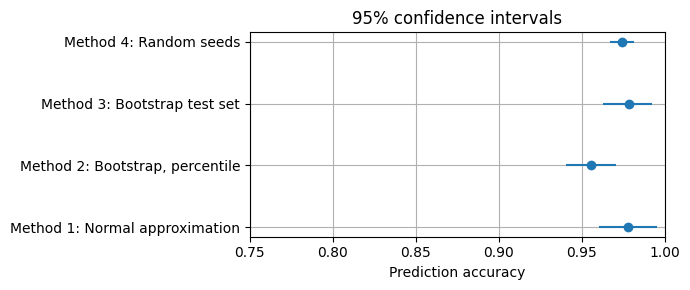

In [ ]:
labels = list(results.keys())

means = np.array([results[k]["Test accuracy"] for k in labels])
lower_error = np.array([results[k]["Lower 95% CI"] for k in labels])
upper_error = np.array([results[k]["Upper 95% CI"] for k in labels])

asymmetric_error = [means - lower_error, upper_error - means]


fig, ax = plt.subplots(figsize=(7, 3))
ax.errorbar(means, np.arange(len(means)), xerr=asymmetric_error, fmt="o")
ax.set_xlim([0.75, 1.0])
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(labels)
ax.set_xlabel("Prediction accuracy")
ax.set_title("95% confidence intervals")

plt.grid()
plt.tight_layout()
plt.show()